In [3]:
import quandl as ql
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib

from math import floor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn import tree

%matplotlib inline

start_date = '2008-01-01'
end_date = '2019-01-4'
key = 'YgkL6nxrm_SsUs7so2MM'

# Multcurrency strategy using Machine Learning

##### This notebook intends to reproduce the analysis found [here](https://www.quantconnect.com/research/cache/36263e80928dd99306a022093b4a6876.html) on [quantconnect](https://www.quantconnect.com/)

+ The original paper is [here](https://www.researchgate.net/publication/281424639_Using_a_principal_component_analysis_for_multi-currencies-trading_in_the_foreign_exchange_market)

In [4]:
pairs = dict(eur_usd="FRED/DEXUSEU", 
             aus_usd='FRED/DEXUSAL', 
            # brl_usd='FRED/DEXBZUS', 
             usd_gbp='FRED/DEXUSUK',
             cad_usd='FRED/DEXCAUS',
             jpy_usd='FRED/DEXJPUS',
            # mxn_usd='FRED/DEXMXUS',
             #usd_rub='BOE/XUDLBK69',
             #usd_try='BOE/XUDLBK75',
             #eur_idr='ECB/EURIDR',
             #eur_jpy='ECB/EURJPY',
             #eur_rub='ECB/EURRUB',
             #eur_try='ECB/EURTRY'
            )

In [5]:
das = []
for k, v in pairs.items():
    data = ql.get(v, start_date='2008-01-01', end_date='2019-01-19', api_key=key)
    das.append(xr.DataArray(data, coords=[data.index, [k]], dims=['Date', 'currency_pair']))
   


In [6]:
ds_currency = xr.concat(das, dim='currency_pair').to_dataset(name='price')   

In [7]:
ds_currency.to_zarr('currency_pairs', 'w')
#ds_currency = xr.open_zarr('currency_pairs/')

#### To perform PCA we need to do the following
+ Standardize the data.
+ Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
+ Sort eigenvalues in descending order and choose the 𝑘 eigenvectors that correspond to the 𝑘 largest eigenvalues where 𝑘 is the number of dimensions of the new feature subspace (𝑘≤𝑑)/.
+ Construct the projection matrix 𝐖 from the selected 𝑘 eigenvectors.
+ Transform the original dataset 𝐗 via 𝐖 to obtain a 𝑘-dimensional feature subspace 𝐘.

In [188]:
ds_currency['price'].load()

<xarray.DataArray 'price' (Date: 2760, currency_pair: 5)>
array([[109.7   ,   0.8812,   1.4738,   1.9824,   0.9922],
       [109.58  ,   0.8819,   1.4736,   1.9733,   0.9905],
       [108.38  ,   0.8762,   1.4786,   1.9757,   0.9988],
       ...,
       [109.22  ,   0.7   ,   1.1357,   1.2598,   1.3591],
       [108.07  ,   0.7014,   1.1399,   1.2633,   1.3484],
       [108.29  ,   0.7108,   1.141 ,   1.274 ,   1.3399]])
Coordinates:
  * Date           (Date) datetime64[ns] 2008-01-02 2008-01-03 2008-01-04 ...
  * currency_pair  (currency_pair) object 'jpy_usd' 'aus_usd' 'eur_usd' ...

#### Because our JPYUSD rates are so much larger than the other rates lets standardize our data

In [191]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(ds_currency.price)

#### Compute the covariance matrix
+ To compute this matrix we need the mean vector and the standardized data matrix
+ We subtract the mean vector from the standardized data matrix
+ Then we take the dot product of the transpose of that matrix and itself. 
+ This matrix is normalize by dividing by one minus the number of observat

In [192]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00036245 -0.74381338 -0.56546973 -0.29270215  0.76465816]
 [-0.74381338  1.00036245  0.6194482   0.54417428 -0.90756589]
 [-0.56546973  0.6194482   1.00036245  0.82553994 -0.8085467 ]
 [-0.29270215  0.54417428  0.82553994  1.00036245 -0.71542786]
 [ 0.76465816 -0.90756589 -0.8085467  -0.71542786  1.00036245]]


In [193]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00036245 -0.74381338 -0.56546973 -0.29270215  0.76465816]
 [-0.74381338  1.00036245  0.6194482   0.54417428 -0.90756589]
 [-0.56546973  0.6194482   1.00036245  0.82553994 -0.8085467 ]
 [-0.29270215  0.54417428  0.82553994  1.00036245 -0.71542786]
 [ 0.76465816 -0.90756589 -0.8085467  -0.71542786  1.00036245]]


In [194]:
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

In [195]:
eigenvalues

array([3.74227655, 0.83316047, 0.28571932, 0.09608199, 0.04457391])

In [196]:
eigenvectors

array([[-0.40277926,  0.59888346,  0.51079742, -0.44396019, -0.14523363],
       [ 0.45965877, -0.30403826,  0.63897851, -0.24771113,  0.47604644],
       [ 0.45720279,  0.35227125, -0.52473141, -0.60066661,  0.17529163],
       [ 0.40353654,  0.64667429,  0.13728099,  0.61254476,  0.15783999],
       [-0.50458552,  0.08134284, -0.19131999,  0.07434441,  0.83465344]])

[0.74818413 0.16657172 0.05712316 0.01920944 0.00891155]


Text(0, 0.5, 'Variance Explained')

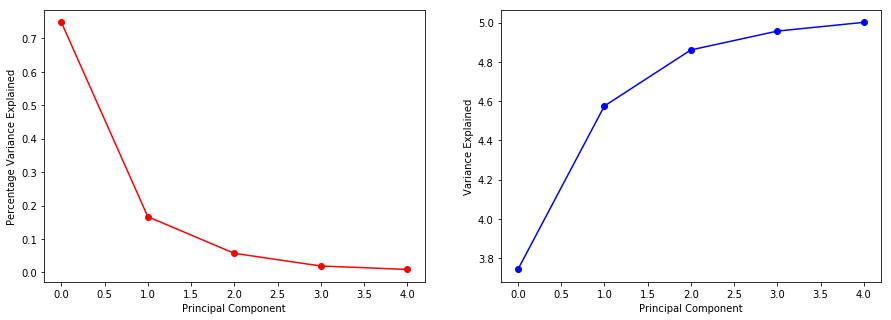

In [197]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)#plot the eigenvalues which is how much of the variance is explained by that compnonent
plt.plot(range(0,len(eigenvalues)),eigenvalues/sum(eigenvalues),'ro-')
print(eigenvalues/sum(eigenvalues))
plt.ylabel('Percentage Variance Explained')
plt.xlabel('Principal Component')
plt.subplot(1,2,2)#plot the cumulative variance of each component
plt.plot(range(0,len(eigenvalues)),np.cumsum(eigenvalues),'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

In [198]:
weights = eigenvectors[0]*eigenvectors[0]
weights



array([0.16223113, 0.3586614 , 0.26091401, 0.19710065, 0.02109281])

In [199]:
np.dot(X_std, eigenvectors[0])

array([-0.46583858, -0.43392081, -0.42213582, ..., -1.16194661,
       -1.10196039, -1.07654441])

The first principal Components is


array([ 2.07150455,  2.06180817,  2.06795457, ..., -2.86542381,
       -2.76271913, -2.67247006])

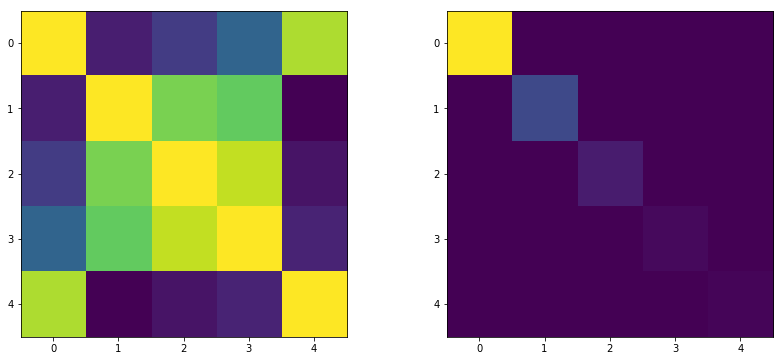

In [200]:
PC = eigenvectors.T.dot(X_std.T)

np.dot(X_std, eigenvectors[0].T)
#principal_components[0]
#norm_price['price'].T.values

plt.figure(figsize=(14,6))
plt.subplot(121); plt.imshow(X_std.T.dot(X_std),interpolation='none')
plt.subplot(122); plt.imshow(PC.dot(PC.T),interpolation='none')

# plt.subplot(133); plt.imshow(PC_new.dot(PC_new.T),interpolation='none')
print("The first principal Components is")
PC_1 = PC[0]
PC_1

##### We use our first principal component for signal generation

In [201]:
g = np.dot(X_std, eigenvectors[0].T)
g = pd.DataFrame({'g':g}, index = ds_currency.Date)
# Generate signals
threshold = 0.02
signal = []
pct_change = g.pct_change().dropna()
for i in pct_change.values:
    if i  > threshold:
        signal.append(1)
    else:
        signal.append(0)
response = pd.DataFrame({'signal':signal}, index = pct_change.index)

In [202]:
#Our raw projection score
len(g)

2760

In [203]:
#our signal is a sequence of 0 and 1
signal[:10]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1]

#### Questions for further review
+ Does every asset have its own projection score g?
+ What do we do with our signal of ones and zeros? Do we multiply it by our weights vector?
+ If not how do the weights factor in here?
+ Are you all long/short in this strategy? 
+ Can you have some scenarios that are long one security and short others?


In [204]:
#from the paper, this value has been determined as the necessary window
#it represents approximately one quarter of the trading years for a given year

period = 55

#Relative position
#Indicates where the spread between todays price and 
#the period minimum sits in relation to the max and min spread for the period. 
RP = []
for i in range(period,len(g)):
    RP.append((g.iloc[i].values-np.min(g.iloc[i-period:i].values))/(np.max(g.iloc[i-period:i].values)-np.min(g.iloc[i-period:i].values))*100)


# Relative strength index  
#RSI helps us understand the general trend and its direction relative some lookback period
#It is scaled and bounded by 0 and 100. Values close to 0 and 100 indicate the strongest trends. 
RSI = talib.RSI(g.values.flatten(), period)
RSI = RSI[~np.isnan(RSI)]

# Momentum
MOM = (g/g.shift(period)).dropna()*100

# Moving average convergence-divergence
#MACD is computed by subtracting the 12-week moving average from the 26 week moving average
#Basically its the difference between two moving average.
#We should experiment with the values to see what actually holds information value
macd_slow = period
macd_fast = int(np.floor(period * 0.5))
MACD, macdsignal, macdhist = talib.MACDEXT(g.values.flatten(), fastperiod=macd_fast, fastmatype=talib.MA_Type.EMA, slowperiod=macd_slow, slowmatype=talib.MA_Type.EMA, signalperiod=2, signalmatype=0)
MACD = MACD[~np.isnan(MACD)]*10000


predictor = pd.DataFrame({'RP': np.array([v[0] for v in RP]), 'RSI':RSI,'MOM':MOM.values.flatten(),'MACD':MACD}, index=g.index[period:])

In [205]:
predictor_var = predictor.values
df = pd.concat([predictor, response], axis=1).dropna()
response_var = df['signal']

In [206]:
X_train, X_test, y_train, y_test = tts(predictor_var, response_var, test_size=0.80, random_state=42)
# from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf = clf.fit(X_train,y_train)
predict_value = clf.predict(X_test)
predict_value.sum()

/Users/justinsimcock/miniconda3/envs/py35_trading/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14

In [207]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
predict_value = clf.predict(X_test)
predict_value.sum()

817

In [208]:

clf = RandomForestClassifier(n_estimators=100,max_depth=4)
clf.fit(X_train,y_train)
predict_value = clf.predict(X_test)
predict_value.sum()

172

#### Pipelining the strategy we need the following routines
+ Do PCA to get principal components
+ compute trade signals according to algo defined in paper
+ compute indicators 
+ Run classifier on data 

In [209]:
#implement PCA
def do_PCA(price_data):
    '''
    Performs PCA on a standardized dataset and 
    the projection of the first eigenvector onto the 
    price data as well as the computing weights. 
    
    
    Parameters
    ==========
    price_data:pd.Dataframe
    
    
    Returns
    =======
    g: pd.DataFrame
    weights: np.array
    
    '''
    
    from sklearn.preprocessing import StandardScaler
    X_std = StandardScaler().fit_transform(price_data)
    
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
    # eigen decomposition of sample covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
    g = X_std.dot(eigenvectors[0].T)    
    weights = eigenvectors[0]*eigenvectors[0]
    return g, weights

#generate signal
def generateSignal(g, threshold):
    '''
    Computes the signal for buying and selling a basket of currencies
    
    Parameters
    ==========
    g: pd.DataFrame
    threshold: float
    
    Returns
    =======
    pd.DataFrame
    
    '''
    
    
    signal = []
    pct_change = g.pct_change().dropna()
    for i in pct_change.values:
        if i  > threshold:
            signal.append(1)
        else:
            signal.append(0)
            
    return pd.DataFrame({'signal':signal}, index = pct_change.index)

#generate the indicators 
def indicator(period,g):
    '''
    Generates a matrix of normalized indicator values from the signal generation process
    The values in g are used as the input to generate the indicators
    
    This matrix is our data matrix for the training/testing period.
    
    
    Parameters
    ==========
    period: int
    g: pd.DataFrame of projection values (floats)
    
    Returns
    =======
    pd.DataFrame of normalized indicators 
    
    '''

    #Relative position
    #Indicates where the spread between todays price and 
    #the period minimum sits in relation to the max and min spread for the period. 
    RP = []
    for i in range(period,len(g)):
        RP.append((g.iloc[i]-np.min(g.iloc[i-period:i]))/(np.max(g.iloc[i-period:i])-np.min(g.iloc[i-period:i]))*100)


    # Relative strength index  
    #RSI helps us understand the general trend and its direction relative some lookback period
    #It is scaled and bounded by 0 and 100. Values close to 0 and 100 indicate the strongest trends. 
    RSI = talib.RSI(g.values.flatten(), period)
    RSI = RSI[~np.isnan(RSI)]

    # Momentum
    MOM = (g/g.shift(period)).dropna()*100

    # Moving average convergence-divergence
    #MACD is computed by subtracting the 12-week moving average from the 26 week moving average
    #Basically its the difference between two moving average.
    #We should experiment with the values to see what actually holds information value
    macd_slow = period
    macd_fast = int(np.floor(period * 0.5))
    MACD, macdsignal, macdhist = talib.MACDEXT(g.values.flatten(), fastperiod=macd_fast, fastmatype=talib.MA_Type.EMA, slowperiod=macd_slow, slowmatype=talib.MA_Type.EMA, signalperiod=2, signalmatype=0)
    MACD = MACD[~np.isnan(MACD)]*10000


    predictor = pd.DataFrame({'RP': np.array([v[0] for v in RP]), 'RSI':RSI,'MOM':MOM.values.flatten(),'MACD':MACD}, index=g.index[period:])

    return predictor

#produce our list of trading predictions
def classifier(ctype,train_x, train_y, test_x):
    '''
    Fits a training set of X's and y's and predicts for out of sample X's in test set
    
    Parameters
    ==========
    ctype: str sklearn classifier 
    train_x: ndarray matrix of values
    train_y: 1D array of targets with same length of train_x
    test_x: ndarray/matrix 
    
    Returns
    =======
    1-D np.array
    '''
    
    if ctype == 'LogisticRegression':

        clf = LogisticRegression()
        
    elif ctype == 'DecisionTree':
        clf = tree.DecisionTreeClassifier()
    
    
    elif ctype == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=100,max_depth=2)
    
    else:
        print('no such classifier')

        
    clf = clf.fit(train_x,train_y)
    predict_value = clf.predict(test_x)
    
    return list(predict_value)

In [214]:
def predict(classifier_type, price_data, period, threshold):
    '''
    Run all the steps of the routine through here
    
    
    Parameters
    ==========
    classifier_type: str
    price_data: xr.Dataset
    period: int
    threshold: float
    
    Returns
    =======
    pd.Dataframe of price and signal 
    '''
    
    df_price = pd.DataFrame(price_data.price.values, 
                            columns=price_data.currency_pair.values, 
                            index=price_data.Date)
    
    
    index = normed_df.index
    num_windows = len(df_price)/period
    length = num_windows * period
    df_price = df_price[int(-length):]

    signal = []
    date = []
    for i in range(0,int(num_windows-2)):
        start = i*period
        stop = (i+3)*period
        df_price_temp = df_price[start:stop]
        g, weights = do_PCA(df_price_temp)
        g = pd.DataFrame({'g':g}, index = df_price_temp.index)

        predictor = indicator(period,g)
        train_x = predictor[:int(len(predictor)/2)]
        train_y = generateSignal(g[int(len(g)/3-1):int(len(g)/3*2)], threshold)
        test_x = predictor[int(len(predictor)/2):]
    
    
        pred_value = classifier(classifier_type, train_x, train_y.values.ravel(), test_x)
        date.extend(test_x.index)
        signal.extend(pred_value)

    df_signal  = pd.DataFrame({'signal':signal},index = date) 
    return pd.concat([df_price, df_signal], axis=1).dropna()

In [215]:
###not my code copied directly from the notebook.
#https://www.quantconnect.com/research/cache/36263e80928dd99306a022093b4a6876.html

class NetProfit:
    """
    This class calculates the net profit for strategy trading individual stock
    
    Args:
        price(pandas.Series) : The price series of stock indexed by date
        signal(pandas.Series): The trading signal series of stock indexed by date (long 1, short -1, holding 0)

    Attributes:
        price(pandas.Series) : The price series of stock indexed by date
        signal(pandas.Series): The trading signal series of stock indexed by date (long 1, short -1, holding 0)
        quantity(pandas.Series): The number of holding shares indexed by date 
    
    Note:
        If there is no quantity, the default value of quantity is 1 share at each time step)       
    """
    
    def __init__(self, price, signal):
        self.price = price
        self.signal = signal
        self.quantity = pd.Series([1]*len(self.price),index = self.price.index)
        
        
    def net_profit(self):
       
        """
        calculate the net profit
        
        Returns(pandas.Series):
                The net profit for strategy        
        """
        #   log_return = np.log(self.price/self.price.shift(1))
        #   cum_return = np.exp(((log_return)*self.signal.shift(1)).cumsum())*self.quantity
        pct_return = self.price.pct_change()
        cum_return = ((pct_return)*self.signal.shift(1) + 1).cumprod()*self.quantity 
        net_profit = cum_return.dropna()*self.price[0] #- self.quantity * self.price[0]
        return net_profit   
    
class PortfolioNetProfit:
    """
    This class calculates the net profit for strategy trading a porfolio of stocks or singal stock
    
    Args:
        data(dict): A dictionary stores the data for multiple stocks 
                    keys(string): 
                                symbols
                    values(dataframe): 
                                Index: date 
                                Columns: ['price','signal','quantity'] or ['price','signal']         
    """
    
    def __init__(self,data):
        self.data = data
        
    def net_profit(self):
        """
        Calculate the net profit for the portfolio
        
        Returns(pandas.Series):
                The net profit for strategy
            
        """
        popped = data_dict.popitem()
        
        net_profit_port = pd.Series([0]*(len(popped[1])),index = popped[1].index)
       
        for i in self.data:
            df = self.data[i]
            net_profit_each = NetProfit(df['price'],df['signal'])
            try:
                net_profit_each.quantity = df['quantity'] # if there is no quantity, the default is 1 
            except:
                pass
            cum_return = net_profit_each.net_profit()
            net_profit_port = net_profit_port.add(cum_return,fill_value=0)        

        return net_profit_port[1:]
    
    def curve(self):
        """
        Plot the equity curve for strategy contain a portfolio of stocks
        """
        net_profit_port = self.net_profit()
        plt.figure(figsize =(15,7))
        plt.plot(net_profit_port.index, net_profit_port,label ='Portfolio Net Profit')
        plt.legend()        

In [212]:
df = predict('RandomForest',ds_currency,period =55,threshold = 0.03)
data_dict = {}
cash_each = 10000

for i in df.columns[:-1]:
    data_dict[i] = pd.DataFrame({'price':df[i].values,
                                 'signal':df['signal'].values}, index = df[i].index) 

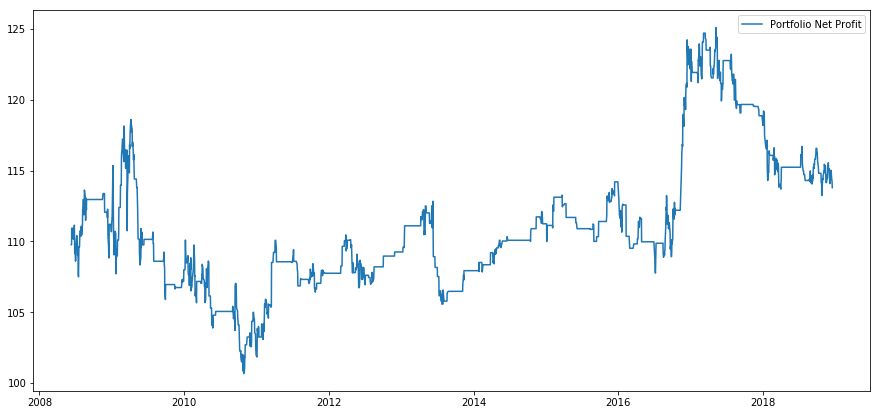

In [213]:
profit_strategy = PortfolioNetProfit(data_dict).net_profit()
# plot the equity curve for the strategy
PortfolioNetProfit(data_dict).curve()